## *Importing the necessary libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/E-com_Data.csv')
data.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177.0,29-10-2017,6.0,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422.0,05-10-2017,2.0,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422.0,12-10-2017,2.0,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633.0,22-08-2017,3.0,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422.0,10-10-2017,2.0,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN


# Choosing the required columns only

In [ ]:
data = data[['CustomerID','Date of purchase','InvoieNo','Price']]

data = data.rename(columns={'InvoieNo' : 'InvoiceNo','Date of purchase' : 'DOP'})

data.head()

,CustomerID,DOP,InvoiceNo,Price
0,4355.0,29-10-2017,398177.0,1926.0
1,4352.0,05-10-2017,394422.0,1740.0
2,4352.0,12-10-2017,394422.0,1866.0
3,4352.0,22-08-2017,388633.0,1869.0
4,4352.0,10-10-2017,394422.0,1888.0


In [ ]:
data.shape

(541116, 4)

# **Missing Values Analysis**

In [ ]:
round(data.isnull().mean()*100,2)

,0
CustomerID,25.30
DOP,0.58
InvoiceNo,0.58
Price,0.58


## Dropping the missing data with more than 25% missing values

In [ ]:
data = data.dropna(subset=['CustomerID'])

round(data.isnull().mean()*100,2)

,0
CustomerID,0.0
DOP,0.0
InvoiceNo,0.0
Price,0.0


## Checking & Treating the Data Duplicacy

In [ ]:
data[data.duplicated()]

,CustomerID,DOP,InvoiceNo,Price
7959,3670.0,27-04-2017,375541.0,804.0
12635,901.0,03-12-2017,404814.0,1395.0
13807,278.0,14-12-2016,363157.0,2028.0
18415,3482.0,13-11-2017,400666.0,566.0
24903,1346.0,24-06-2017,382823.0,2700.0
...,...,...,...,...
536824,4198.0,25-09-2017,392192.0,2316.0
536838,4043.0,14-11-2017,399611.0,518.0
537393,1234.0,26-09-2017,392883.0,2048.0
537654,3223.0,08-10-2017,394523.0,6048.0


In [ ]:
print('No. of duplicated rows in the data before treating', data.duplicated().sum() )
data = data.drop_duplicates(ignore_index=False)
print('No. of duplicated rows in the data after treating', data.duplicated().sum() )


No. of duplicated rows in the data before treating 1330
No. of duplicated rows in the data after treating 0


## Handling the data types

In [ ]:
data.dtypes

,0
CustomerID,float64
DOP,object
InvoiceNo,float64
Price,float64


## Changing the data types wherever required

In [ ]:
data['CustomerID'] = data['CustomerID'].astype(int)
data['InvoiceNo'] = data['InvoiceNo'].astype(int)
data['DOP'] = pd.to_datetime(data['DOP'])

data.dtypes

,0
CustomerID,int64
DOP,datetime64[ns]
InvoiceNo,int64
Price,float64


In [ ]:
# Last day of purchase
data['DOP'].max()

Timestamp('2017-12-19 00:00:00')

In [ ]:
# Latest date of purchase
latest_date = dt.datetime(2017,12,20)
latest_date

datetime.datetime(2017, 12, 20, 0, 0)

# RFM Analysis

In [ ]:
RFMScore = data.groupby('CustomerID').agg({'DOP': lambda x: (latest_date - x.max()).days,  #recency
                                        'InvoiceNo': lambda x: x.count(),                    #Frequency
                                        'Price': lambda x: x.sum()})                        #Monetory

# Renaming the columns
RFMScore.rename(columns={'DOP': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Price': 'Monetary'}, inplace=True)

RFMScore.head()

,Recency,Frequency,Monetary
CustomerID,,,
2,4,181,550416.0
3,77,27,257404.0
4,19,72,176613.0
5,311,16,41976.0
6,37,84,151822.0


## Code Explanation
- Recency (DOP) →
(latest_date - x.max()).days calculates the number of days since the most recent purchase of a customer.

    Smaller = more recent purchase (better customer).

- Frequency (InvoiceNo) →
x.count() counts how many transactions a customer made.

    Larger = more frequent (better customer).

- Monetary (Price) →
x.sum() gives the total spending of a customer.

    Larger = higher value (better customer).



In [ ]:
RFMScore.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,2,4,181,550416.0
1,3,77,27,257404.0
2,4,19,72,176613.0
3,5,311,16,41976.0
4,6,37,84,151822.0


In [ ]:
for cols in RFMScore.columns :
  print(f'For {cols}, the min value is {RFMScore[cols].min()} and the max value is {RFMScore[cols].max()}')


For Recency, the min value is 1 and the max value is 381
For Frequency, the min value is 1 and the max value is 7919
For Monetary, the min value is -50372.0 and the max value is 35472089.0


In [ ]:
## Quantile for splitting the data

quantile = RFMScore.quantile(q=[0.25,0.5,0.75])
quantile = quantile.to_dict()
quantile

# For each column (Recency, Frequency, Monetary), we calculate the 25th, 50th, and 75th percentiles.
# Converted to a dictionary for easier access.

{'Recency': {0.25: 18.0, 0.5: 51.0, 0.75: 144.0},
 'Frequency': {0.25: 17.0, 0.5: 42.0, 0.75: 101.0},
 'Monetary': {0.25: 38140.0, 0.5: 83635.0, 0.75: 205444.0}}

In [ ]:
## Functions for the scores and labels
def recency_score(x,q,d):
    if x <= d[q][0.25]:
        return 1
    elif x <= d[q][0.50] :
        return 2
    elif x <= d[q][0.75] :
        return 3
    else :
        return 4

# Here lower Recency = better (because “recent purchase” is good).
# So we’re correctly giving lower scores for lower recency (1 = very recent).


def FnM_score(x,q,d):
    if x <= d[q][0.25]:
        return 4
    elif x <= d[q][0.50] :
        return 3
    elif x <= d[q][0.75] :
        return 2
    else :
        return 1

# Here, higher Frequency and Monetary = better.
# So we flipped the scoring (low F/M → worse score = 4, high F/M → better score = 1).



In [ ]:
## Applying the functions to the columns

RFMScore['R_Score'] = RFMScore['Recency'].apply(recency_score, args=('Recency',quantile))
RFMScore['F_Score'] = RFMScore['Frequency'].apply(FnM_score, args=('Frequency',quantile))
RFMScore['M_Score'] = RFMScore['Monetary'].apply(FnM_score, args=('Monetary',quantile))
RFMScore

# For every row in the Recency column, the function recency_score() is applied.
# args=('Recency', quantile) passes the string "Recency" and the quantile dictionary to the function.
# Based on quantile thresholds, each customer gets a Recency score (1–4).
# Same logic for Frequency and Monetary, but since higher values are better, the FnM_score function flips the scale.


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
2,4,181,550416.0,1,1,1
3,77,27,257404.0,3,3,1
4,19,72,176613.0,2,2,2
5,311,16,41976.0,4,4,3
6,37,84,151822.0,2,2,2
...,...,...,...,...,...,...
4368,278,10,20480.0,4,4,4
4369,181,7,10774.0,4,4,4
4370,9,13,24962.0,1,4,4


In [ ]:
# Loyality score

RFMScore['Loyality_Score'] = RFMScore[['R_Score','F_Score','M_Score']].sum(axis=1)
RFMScore.head()


#Min score = 3 (1+1+1) → Best customers (most recent, frequent, and highest spenders).
#Max score = 12 (4+4+4) → Worst customers (least recent, infrequent, and low spenders).
#So lower Loyalty Score = higher loyalty, and higher Loyalty Score = weaker loyalty.



,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Loyality_Score
CustomerID,,,,,,,
2,4,181,550416.0,1,1,1,3
3,77,27,257404.0,3,3,1,7
4,19,72,176613.0,2,2,2,6
5,311,16,41976.0,4,4,3,11
6,37,84,151822.0,2,2,2,6


In [ ]:
# loyality Badge

badge = ['Platinum','Gold','Silver','Bronze']
RFMScore['LoyalityBadge'] = pd.qcut(RFMScore['Loyality_Score'], q=4, labels=badge)
RFMScore.head()

# pd.qcut(..., q=4, labels=badge) splits our Loyality_Score into 4 quantile-based bins.
# Customers with lowest scores (best customers) → "Platinum".
# Next group → "Gold".
# Then "Silver".
# Highest scores (weakest loyalty) → "Bronze".

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Loyality_Score,LoyalityBadge
CustomerID,,,,,,,,
2,4,181,550416.0,1,1,1,3,Platinum
3,77,27,257404.0,3,3,1,7,Gold
4,19,72,176613.0,2,2,2,6,Gold
5,311,16,41976.0,4,4,3,11,Bronze
6,37,84,151822.0,2,2,2,6,Gold


In [ ]:
# Segmented data
segmented_data = RFMScore.reset_index()
segmented_data = segmented_data[['CustomerID','Recency','Frequency','Monetary','LoyalityBadge']]

segmented_data.head()

# reset_index()
# Moves CustomerID from the index back into a normal column.
# This is helpful if you want to export or merge with other data.



,CustomerID,Recency,Frequency,Monetary,LoyalityBadge
0,2,4,181,550416.0,Platinum
1,3,77,27,257404.0,Gold
2,4,19,72,176613.0,Gold
3,5,311,16,41976.0,Bronze
4,6,37,84,151822.0,Gold


## Data Visualization

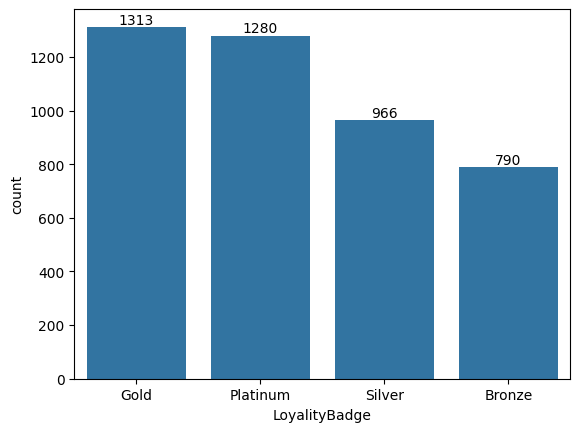

In [ ]:
ax = sns.countplot(x='LoyalityBadge', data=segmented_data, order = segmented_data['LoyalityBadge'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

# Finally segmented customers according to their loyalty scores

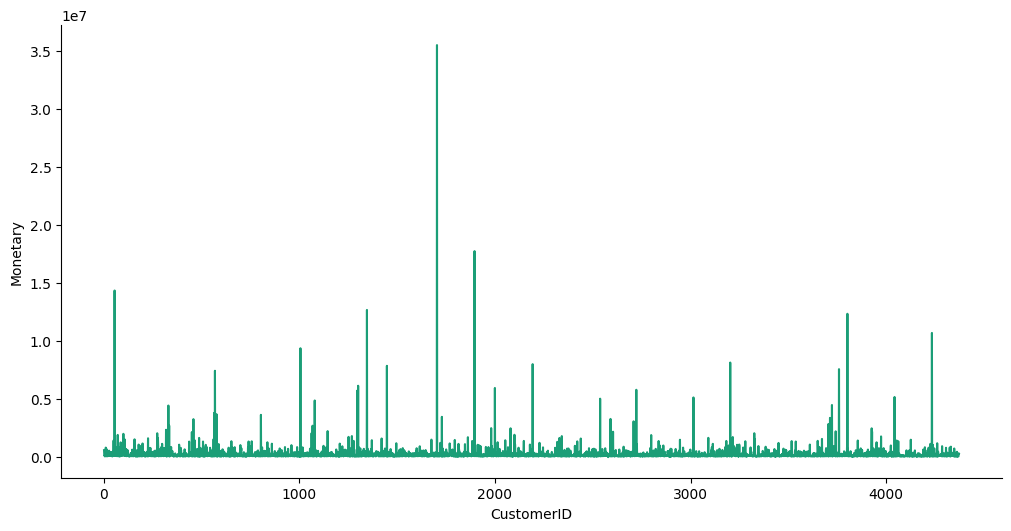

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CustomerID']
  ys = series['Monetary']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = segmented_data.sort_values('CustomerID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CustomerID')
_ = plt.ylabel('Monetary')

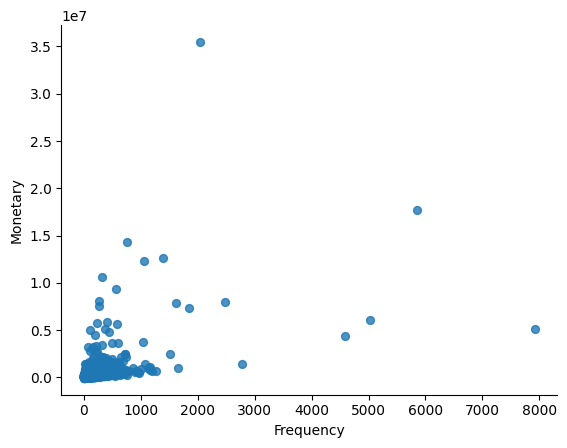

In [ ]:
from matplotlib import pyplot as plt
segmented_data.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

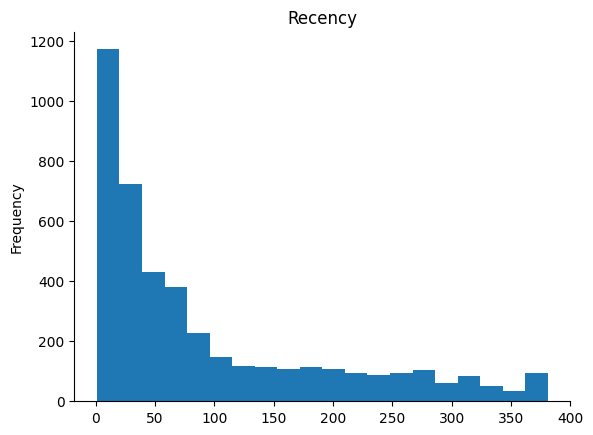

In [ ]:
from matplotlib import pyplot as plt
segmented_data['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
segmented_data.to_csv('/content/sample_data/segmented_data.csv')

In [ ]:
segmented_data.sort_values(by='Recency', ascending=True).head(10)

,CustomerID,Recency,Frequency,Monetary,LoyalityBadge
1525,1535,1,217,553702.0,Platinum
1542,1552,1,291,146957.0,Platinum
3146,3163,1,184,567483.0,Platinum
3097,3114,1,473,1095714.0,Platinum
1260,1269,1,214,1764541.0,Platinum
3423,3441,1,169,497679.0,Platinum
70,72,1,418,1864111.0,Platinum
1060,1068,1,213,2657603.0,Platinum
3672,3692,1,412,578816.0,Platinum
808,816,1,158,462629.0,Platinum


In [ ]:
segmented_data.sort_values(by='Frequency', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,LoyalityBadge
4021,4043,2,7919,5134340.0,Platinum
1886,1896,2,5854,17710859.0,Platinum
1292,1301,5,5023,6102150.0,Platinum
326,331,1,4592,4396368.0,Platinum
1665,1675,2,2775,1455036.0,Platinum
2181,2193,1,2487,7965268.0,Platinum
1694,1704,3,2045,35472089.0,Platinum
564,569,5,1848,7394059.0,Platinum
691,699,2,1662,986014.0,Platinum
1438,1448,5,1617,7820889.0,Platinum


In [ ]:
segmented_data.sort_values(by='Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,LoyalityBadge
1694,1704,3,2045,35472089.0,Platinum
1886,1896,2,5854,17710859.0,Platinum
54,56,25,755,14312274.0,Platinum
1337,1346,10,1390,12637501.0,Platinum
3780,3802,3,1059,12307199.0,Platinum
4211,4234,3,322,10654918.0,Platinum
998,1006,5,569,9335851.0,Platinum
3186,3203,5,269,8102167.0,Platinum
2181,2193,1,2487,7965268.0,Platinum
1438,1448,5,1617,7820889.0,Platinum


In [ ]:
def Cust_Badge_Checker(Cust_ID) :
    if Cust_ID in segmented_data['CustomerID'].values:
        return segmented_data.loc[segmented_data['CustomerID'] == Cust_ID, 'LoyalityBadge'].iloc[0]
    else:
        return "Customer ID not found"

In [ ]:
Cust_Badge_Checker(56)

'Platinum'

In [ ]:
Cust_Badge_Checker(3002)

'Silver'

## Based on the RFM analysis and segmentation, we can glean the following insights:
- Customer Distribution: The customer base is segmented into four loyalty badges: Platinum, Gold, Silver, and Bronze. The count plot shows the distribution of customers within each segment, indicating the size of each loyalty group.
- Platinum Customers: These are the most valuable customers, characterized by high recency (recent purchases), high frequency (frequent purchases), and high monetary value (high spending). The sorted lists confirm that customers with low Recency values and high Frequency and Monetary values are indeed assigned the Platinum badge.
- Bronze Customers: These customers are at the other end of the spectrum, with low recency, low frequency, and low monetary value.
- Monetary Value Distribution: The line plot of Monetary value by CustomerID shows that while most customers have relatively lower spending, there are a few outliers with very high monetary values. These high-spending customers are likely to be in the Platinum segment.
- Frequency vs. Monetary: The scatter plot of Frequency vs. Monetary shows a general positive correlation, meaning customers who purchase more frequently tend to spend more. However, there are also customers with high monetary value but not necessarily the highest frequency, and vice versa.
- Recency Distribution: The histogram of Recency shows that a large number of customers have made a purchase recently (low Recency values), which is a positive sign for customer engagement. There is a tail of customers with higher Recency values, indicating a segment of less recently engaged customers.
- Customer Badge Checker: The Cust_Badge_Checker function allows for quickly looking up the loyalty badge of a specific customer, which can be useful for targeted marketing or customer service efforts.

Overall, the RFM analysis provides a clear picture of the customer base's value and behavior, enabling targeted strategies for customer retention, engagement, and acquisition based on their loyalty segment.